# Simulating lightcurves using the magnetar model from Nicholl+ 2017

In [1]:
import os
os.environ["HOME"] = "/data/asingh/simsurvey"
home_dir = os.environ.get('HOME')

DIR_DATA = "/data/cfremling/simsurvey"
survey_file = os.path.join(DIR_DATA, 'data/test_schedule_v6.db')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
# survey_file = os.path.join(home_dir, 'data/ZTF/test_schedule_v6.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import Planck15
import simsurvey
import sncosmo

from scipy.interpolate import (InterpolatedUnivariateSpline as Spline1d,
                               RectBivariateSpline as Spline2d)

from scipy.integrate import cumtrapz

import simsurvey_tools as sst

In [3]:
# Load the ZTF CCD corners and filters
ccds = sst.load_ztf_ccds()
sst.load_ztf_filters()

In [4]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr', 'i': 'desi'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)

In [5]:
def blackbody_old(wl, T=6e3, R=1., d=1e-5):
    # wl in Ångströms
    # T in Kelvin
    # R in cm
    # d in Mpc
    # output in erg s^-1 cm^-2 Angstrom^-1
    B = 1.19104295262e+27 * wl**-5 / (np.exp(1.43877735383e+8 / (wl*T)) - 1)
    return B * (R/(d*3.0857e24))**2


def blackbody(wl, T=6e3, R=1., d=1e-5):
    # wl in Ångströms
    # T in Kelvin
    # R in cm
    # d in Mpc
    # output in erg s^-1 cm^-2 Angstrom^-1
    B = 1.19104e+27 * (wl ** -5) / (np.exp(1.4405e+8 / (wl * T)) - 1)
    return np.pi * (B * (R / (d *3.0857e24)) ** 2)

In [6]:
class MagnetarSource(sncosmo.Source):
    """Units:
    distance    -- Mpc
    P           -- ms
    B           -- G
    M_ej        -- M_sun
    v_ej        -- 10^3 km/s
    M_NS        -- M_sun
    kappa       -- cm^2/g
    kappa_gamma -- cm^2/g
    T_f         -- K
    """
    _param_names = ['distance', 'P', 'B', 'M_ej', 'v_ej', 'M_NS', 'kappa', 'kappa_gamma', 'T_f']
    param_names_latex = ['d', 'P', 'B', 'M_{ej}', 'v_{ej}', 'M_{NS}', '\kappa', '\kappa_\gamma', 'T_f']
    
    def __init__(self, name=None, version=None, minphase=0.01, maxphase=300.,
                 phase_sampling=1000):
        self.name = name
        self.version = version
        self._minphase = minphase
        self._maxphase = maxphase
        self._phase_sampling = phase_sampling

        self._parameters = np.array([1e-5, 0.7, 0.01, 0.1, 14.7, 1.4, 0.05, 0.01, 6e3])

        self._set_L_out()
        
    def minwave(self):  
        return 1e-100

    def maxwave(self):  
        return 1e100
    
    def minphase(self):
        return self._minphase

    def maxphase(self):
        return self._maxphase

    @property
    def _E_mag(self):
        """eq (3) of Nicholl+ 2017"""
        print (2.6e52 * (self._parameters[5]/1.4)**1.5 * self._parameters[1]**-2)
        return 2.6e52 * (self._parameters[5]/1.4)**1.5 * self._parameters[1]**-2
    

    @property
    def _t_mag(self):
        """eq (4) of Nicholl+ 2017"""
        print (1.3e5 * (self._parameters[5]/1.4)**1.5 * self._parameters[1]**2
                * (self._parameters[2]/1e14)**-2)
        return (1.3e5 * (self._parameters[5]/1.4)**1.5 * self._parameters[1]**2
                * (self._parameters[2]/1e14)**-2)

    @property
    def _t_diff(self):
        """eq (6) of Nicholl+ 2017"""
        print (9.84e6*(self._parameters[6] * self._parameters[3]
                        / self._parameters[4])**0.5)
        return (9.84e6*(self._parameters[6] * self._parameters[3]
                        / self._parameters[4])**0.5)

    @property
    def _A(self):
        """eq (7) Of Nicholl+ 2017"""
        print (4.77e16 * self._parameters[7] * self._parameters[3] / self._parameters[4]**2)
        return 4.77e16 * self._parameters[7] * self._parameters[3] / self._parameters[4]**2

    @property
    def _is_L_out_set(self):
        return np.all(self._parameters[1:] == self._L_out_parameters)
    
    def _set_L_out(self):
        """Solving the integral in eq (4) of Nicholl+ 2017
        using scipy.integrate.cumtrapz (cumulative trapezoidal) and
        then interpolate between the steps 
        """
        t = np.linspace(self._minphase, self._maxphase, self._phase_sampling)*8.64e4

        y = (2 * self._E_mag / self._t_mag / (1+t/self._t_mag)**2
             * t/self._t_diff**2 * np.exp((t/self._t_diff)**2))

        y_int = np.append([0], cumtrapz(y, t))
        L_out_steps = np.exp(-(t/self._t_diff)**2) * (1 - np.exp(-self._A*t**-2)) * y_int

        
        self._L_out = Spline1d(t/8.64e4, L_out_steps)
        self._L_out_parameters = self.parameters[1:]

    def _T_from_L(self, phase):
        """Term in eqs (8) and (9) of Nicholl+ 2017 that is compared to T_f"""
        return (self._L_out(phase)/(7.1256e-4*(self._parameters[4]*phase*8.64e12)**2))**0.25
        
    def temperature(self, phase):
        """eq (8) of Nicholl+ 2017"""
        if not self._is_L_out_set:
            self._set_L_out()
            
        T = self._T_from_L(phase)
        try:
            T[T <= self._parameters[8]] = self._parameters[8]
        except TypeError:
            if T <= self._parameters[8]:
#                 print ("Temperature - ", self._parameters[8])
                return self._parameters[8]
#         print ("Temperature - ", T)
        return T
        
    def radius(self, phase):
        """eq (9) of Nicholl+ 2017 in cm"""
        if not self._is_L_out_set:
            self._set_L_out()

        R = self._parameters[4] * phase * 8.64e12
        T = self._T_from_L(phase)
        mask = T <= self._parameters[8]
        try:
            R[mask] = (self._L_out(phase[mask])  / (7.1256e-4*self._parameters[8]**4))**0.5
        except TypeError:
            if T <= self._parameters[8]:
                return (self._L_out(phase)/(7.1256e-4*self._parameters[8]**4))**0.5
        return R
    
    def luminosity(self, phase):
        """Luminosity from Stefan-Boltzman law using eqs (8) and (9) in erg/s"""
        if not self._is_L_out_set:
            self._set_L_out()
            
        return 7.1256e-4 * self.temperature(phase)**4 * self.radius(phase)**2
    
    def _flux(self, phase, wave):
        """"""
        if not self._is_L_out_set:
            self._set_L_out()
            
        wave = np.array(wave)
        return np.array([blackbody(wave, 
                                   T=self.temperature(p_),
                                   R=self.radius(p_),
                                   d=self._parameters[0]) 
                         for p_ in phase])

In [7]:
# Create the Source object defined in the cell above
source = MagnetarSource()

# Create the model that combines it with propagation effects
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,
                      effects=[dust],
                      effect_names=['host'],
                      effect_frames=['rest'])

5.306122448979591e+52
6.37e+36
6.37e+36
181476.93393657613
181476.93393657613
181476.93393657613
220741357767.59686


/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in exp
/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in multiply
/data/lyan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:321: RuntimeWarning: overflow encountered in multiply
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)
/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply


In [8]:
# Fit results from Table 3 of Nicholl+ 2017 (units as in docstring of MagnetarSource)

SLSN_prop = {
    'P': [4.78, 2.93, 2.28],
    'B': [2.03e14, 1.23e14, 1.8e13],
    'M_ej': [2.19, 4.54, 6.27],
    'v_ej': [5.12, 9.02, 7.01],
    'kappa': [0.1, 0.16, 0.16],
    'kappa_gamma': [0.06, 0.57, 0.01],
    'M_NS': [1.85, 1.83, 1.83],
    'T_f': [6.58e3, 8e3, 6.48e3]
}

def random_parameters(redshifts, model,
                      r_v=2., ebv_rate=0.11,
                      cosmo = Planck15,
                      **kwargs):
    out = {'distance': np.array(cosmo.luminosity_distance(redshifts).value)}
    
    idx = np.random.randint(2, len(SLSN_prop['P']), len(redshifts))
    for k, v in SLSN_prop.items():
        out[k] = np.array(v)[idx]
        
    return out 

In [9]:
np.random.randint(0, len(SLSN_prop.keys()), 100)

array([7, 2, 5, 0, 3, 6, 7, 1, 5, 4, 3, 3, 7, 4, 3, 4, 0, 4, 2, 5, 5, 4,
       2, 4, 5, 7, 1, 7, 2, 4, 4, 2, 4, 0, 1, 6, 6, 2, 4, 0, 6, 7, 7, 3,
       4, 7, 5, 4, 6, 3, 3, 1, 5, 2, 4, 7, 2, 6, 4, 1, 3, 2, 0, 6, 0, 4,
       6, 0, 6, 1, 0, 4, 3, 3, 0, 2, 0, 4, 0, 7, 4, 4, 7, 5, 0, 7, 4, 3,
       6, 0, 0, 2, 7, 7, 7, 1, 7, 3, 5, 2])

In [10]:
tr_prop = {
    'lcmodel': model,
    'lcsimul_func': random_parameters
}

tr = simsurvey.get_transient_generator((0., 0.2),
                                       ratefunc=lambda z: 2.5e-7,
                                       dec_range=(-30,90),
                                       mjd_range=(mjd_range[0], mjd_range[1]),
                                       sfd98_dir=sfd98_dir,
                                       transientprop=tr_prop)

In [11]:
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
    
lcs = survey.get_lightcurves(progress_bar=True, notebook=True) # If you get an error because of the progress_bar, delete this line.


Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)

7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.

/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.

7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.

7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.

7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52
7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.

In [12]:
print(len(lcs.lcs))
lcs.save("LCS_SLSN_UliMagnetar.pkl")

188


In [13]:
# lcs[0]

In [14]:
# lcs[0].meta

In [15]:
# sncosmo.plot_lc(lcs[0])

In [16]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Light Curves from the Pickle File
# Filter the Simulated Light Curves Data 
# ------------------------------------------------------------------------------------------------------------------- #
import pickle
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

gallat_cutoff = 10
mag_band = 'ztfr'
mag_cutoff = 19.5
npoints = 4

dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}


def filter_lcdata(inp_data):
    """
    Filter the Simulated Light Curves data from simsurvey.
    Args:
    inp_data  : Simulated light curves data
    Returns:
    out_data  : Filtered light curves data with necessary requirements
    """
    drop_indices = []
    for lc in range(len(inp_data['lcs'])):
        lc_df = pd.DataFrame(data=inp_data['lcs'][lc], columns=inp_data['lcs'][0].dtype.names)
        lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
        lc_df['phase'] = lc_df['time'] - inp_data['meta']['t0'][lc]
        lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']

        # Keep the LC points that have an SNR greater than 3
        lc_df = lc_df[lc_df['snr'] >= 3]

        temp_df = lc_df.loc[(lc_df['band'] == mag_band) & (lc_df['mag'] <= mag_cutoff)]

        # Check for LCs that adhere to the Apparent Magnitude cutoff
        if temp_df.shape[0] < npoints:
            drop_indices.append(lc)
            continue

        # Check whether a minimum of 4 detections above the cutoff are separated by atleast 12 hrs.
        else:
            time_diff = np.diff(temp_df['time'].values)
            points_diff = len([val for val in time_diff if abs(val) >= 0.5])
            if points_diff < npoints - 1:
                drop_indices.append(lc)
                continue
                
            # Check whether there are 3 detections before the maximum or peak <= 18.5 mag
            else:
                maxmag = temp_df['mag'].min()
                ep_max = temp_df.loc[temp_df['mag'] == maxmag, 'phase'].values[0]

                if (temp_df[temp_df['phase'] < ep_max].shape[0] >= npoints - 1) or (maxmag <= 18.5):
                    pass
                else:
                    drop_indices.append(lc)
                    continue

        # Check for LCs that do not adhere to Galactic Latitude cutoff
        ra, dec = inp_data['meta']['ra'][lc], inp_data['meta']['dec'][lc]
        coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

        if abs(coord.galactic.b.degree) < gallat_cutoff:
            drop_indices.append(lc)
            
    out_data = inp_data.copy()
    for val in sorted(drop_indices, reverse=True):
        del(out_data['lcs'][val])
    for key in [x for x in out_data.keys() if x in['meta', 'stats']]:
        for val in out_data[key].keys():
            if not val in ['p_binned', 'mag_max']:
                out_data[key][val] = np.delete(out_data[key][val], drop_indices, 0)
            else:
                for subkey in out_data[key][val].keys():
                    out_data[key][val][subkey] = np.delete(out_data[key][val][subkey], drop_indices, 0)

    return out_data

data_raw = pickle.load(open('LCS_SLSN_UliMagnetar.pkl', 'rb'))
lcs_raw = simsurvey.LightcurveCollection(load='LCS_SLSN_UliMagnetar.pkl')
print (len(lcs_raw.lcs))

data_mod = filter_lcdata(data_raw)
pickle.dump(data_mod, open('LCS_SLSN_UliFilteredMagnetar.pkl', 'wb'))
lcs = simsurvey.LightcurveCollection(load='LCS_SLSN_UliFilteredMagnetar.pkl')
print (len(lcs.lcs))
# ------------------------------------------------------------------------------------------------------------------- #


188


/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


105


7.4746047934453e+51
31171135.08117071
31171135.08117071
3722458.3842205573
3722458.3842205573
3722458.3842205573
60862513507298.52


/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log10


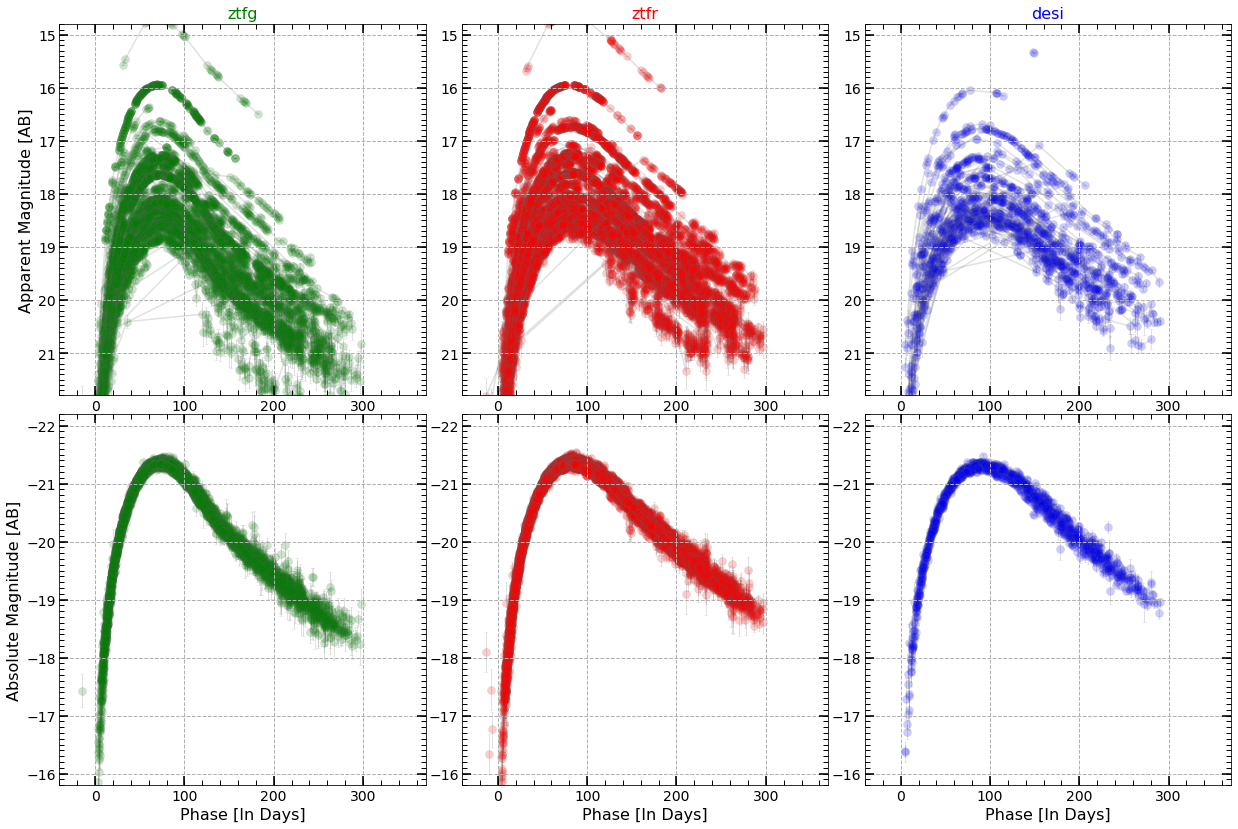

In [17]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot the Combine Results of the Simulated Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

def set_plotparams(ax_obj, xticks=(100, 20), yticks=(1, 0.1), fs=14):
    """
    Sets plot parameters for plotting Simulated Light Curves.
    """
    ax_obj.grid(True, which='major', ls='--', lw=1)
    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=fs)

def set_plotsingle(lc, band, ax_obj1, ax_obj2, corr, data=data_mod):
    """
    Sets plot parameters for plotting individual Simulated Light Curve.
    """
    appmin = df['mag'].max()
    appmax = df['mag'].min()

    ax_obj1.set_ylim(appmin + 0.5, appmax - 0.5)
    ax_obj2.set_ylim(appmin - corr + 0.5, appmax - corr - 0.5)
    
    ep_det = data['stats']['p_det'][lc]
    ep_last = data['stats']['p_last'][lc]
    mag_max = data['stats']['mag_max'][band][lc]

    ax_obj1.axvline(0, ls='-', lw=2, color='k')
    ax_obj2.axvline(0, ls='-', lw=2, color='k')
    ax_obj1.axvline(ep_det, ls='-', lw=2, color='navy')
    ax_obj2.axvline(ep_det, ls='-', lw=2, color='navy')
    ax_obj1.axvline(ep_last, ls='-', lw=2, color='navy')
    ax_obj2.axvline(ep_last, ls='-', lw=2, color='navy')
    ax_obj1.axhline(appmax, ls='-', lw=2, color='k')
    ax_obj2.axhline(appmax - corr, ls='-', lw=2, color='k')
    
    ax_obj1.text(-11, appmax + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj2.text(-11, appmax - corr + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_det - 11, appmax + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_det - 11, appmax - corr + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_last - 11, appmax + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_last - 11, appmax - corr + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj1.text(100, appmax - 0.05, 'Maximum Magnitude', fontsize=10)
    ax_obj2.text(100, appmax - corr - 0.05, 'Maximum Magnitude', fontsize=10)
    

def plot_lcs(ax, df, lc, band, data=data_mod, alpha=0.5, single=False):
    """
    Plots the Simulated Light Curves in a 2 x 3 Grid with 2 rows depicting the Apparent 
    and the Absolute Light Curves, respectively whereas the 3 columns depict the different 
    ZTF filters.
    """
    if band == 'ztfg':
        index = 0
        color = 'g'
    elif band == 'ztfr':
        index = 1
        color = 'r'
    elif band == 'desi':
        index =  2
        color = 'blue'

    ax_obj1 = ax[0][index]
    ax_obj2 = ax[1][index]

    zlc = data['meta']['z'][lc]
    distlc = Planck15.luminosity_distance(zlc).value
    distmag = 5 * np.log10(distlc * 1e6) - 5
    corr = distmag + data['meta']['mwebv_sfd98'][lc] * dict_rlambda[band]
        
    ax_obj1.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], ms=8, alpha=alpha,
                    color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', ls='-', 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    ax_obj2.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'] - corr, yerr=df['magerr'], ms=8, 
                     alpha=alpha, color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
                     ls='', capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    
    set_plotparams(ax_obj1)
    set_plotparams(ax_obj2)
    
    if single:
        set_plotsingle(lc, band, ax_obj1, ax_obj2, corr=corr, data=data)
    else:
        ax_obj1.set_ylim(21.8, 14.8)
        ax_obj2.set_ylim(-15.8, -22.2)

    ax_obj1.set_xlim(-40, 370)
    ax_obj2.set_xlim(-40, 370)
    ax_obj1.set_title(band, color=color, fontsize=16)
    ax_obj2.set_xlabel('Phase [In Days]', fontsize=16)


for (param, val) in SLSN_prop.items():
    model[param] = val[2]
model.set(z=0.107)

phase_arr = np.arange(0, 400, 1)
rmag = model.bandmag('ztfr', 'ab', phase_arr)
gmag = model.bandmag('ztfg', 'ab', phase_arr)
imag = model.bandmag('desi', 'ab', phase_arr)

fig, ax = plt.subplots(2, 3, figsize=(21, 14))

for lc in range(len(data_mod['lcs'])):
    lc_df = pd.DataFrame(data=data_mod['lcs'][lc], columns=data_mod['lcs'][0].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df = lc_df[lc_df['snr'] >= 3]
    
    for band, df in lc_df.groupby('band'):
        plot_lcs(ax, df, lc, band, alpha=0.2)

ax[1][0].plot(phase_arr, gmag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][1].plot(phase_arr, rmag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][2].plot(phase_arr, imag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

ax[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig.subplots_adjust(hspace=0.05, wspace=0.10)
fig.savefig('PLOT_LCS_Magnetar.pdf', format='pdf', dpi=2000, bbox_inches='tight')

plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

In [18]:
for (param, val) in SLSN_prop.items():
    model[param] = val[2]
model.set(distance=Planck15.luminosity_distance(0.107).value)
print (model)

phase_arr = np.arange(0, 400, 1)
rmag = model.bandmag('ztfr', 'ab', phase_arr)
gmag = model.bandmag('ztfg', 'ab', phase_arr)
imag = model.bandmag('desi', 'ab', phase_arr)
print (rmag)

source:
  class      : MagnetarSource
  name       : None
  version    : None
  phases     : [0.01, .., 300] days
  wavelengths: [1e-100, .., 1e+100] Angstroms
effect (name='host' frame='rest'):
  class           : CCM89Dust
  wavelength range: [1000, 33333.3] Angstroms
effect (name='mw' frame='obs'):
  class           : CCM89Dust
  wavelength range: [1000, 33333.3] Angstroms
parameters:
  z           = 0.107
  t0          = 57502.10097966344
  distance    = 510.96794536116175
  P           = 2.28
  B           = 18000000000000.0
  M_ej        = 6.27
  v_ej        = 7.01
  M_NS        = 1.83
  kappa       = 0.16
  kappa_gamma = 0.01
  T_f         = 6480.0
  hostebv     = 0.0
  hostr_v     = 3.1
  mwebv       = 0.050554806371820915
  mwr_v       = 3.1
[-0.27043003 -0.27038645 -0.27034287 -0.27029929 -0.27025571 -0.27021212
 -0.27016854 -0.27012496 -0.27008137 -0.27003778 -0.2699942  -0.26995061
 -0.26990702 -0.26986343 -0.26981984 -0.26977625 -0.26973266 -0.26968907
 -0.26964548 -0.2696